download CommonGen dataset first from https://inklab.usc.edu/CommonGen/

In [1]:
import json
import numpy as np
from itertools import combinations
from tqdm import tqdm
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import torch

random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
p2n = {}
n2s = {}

lines = []
with open("commongen.train.jsonl") as f:
    lines += f.readlines()
with open("commongen.dev.jsonl") as f:
    lines += f.readlines()

for line in tqdm(lines):
    d = json.loads(line)
    concepts = tuple(d["concept_set"].split('#'))
    for p in list(sorted(combinations(concepts, 2))):
        if p not in p2n:
            p2n[p] = set([concepts])
        else:
            p2n[p].add(concepts)
    
    n2s[concepts] = d["scene"]

100%|██████████| 33644/33644 [00:00<00:00, 68565.71it/s] 


In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
entitypairs = []
concepts = []
sentences = []
statistics = []

value_list = list(p2n.keys())
random.shuffle(value_list)
for k in tqdm(value_list):
    paths = list(p2n[k])

    sent = []
    paths_new = []
    for p in paths:
        sent += n2s[p]
        paths_new += [p for i in range(len(n2s[p]))]
    
    threshold = 0.75
    document_embedding = model.encode(sent)
    similarities = cosine_similarity(document_embedding, document_embedding)
    index = [0]
    for i in range(1, len(sent)):
        index.append(i)
        for j in index[:-1]:
            if similarities[i][j] > threshold:
                index = index[:-1]
                break
    
    if len(index) < 3:  # each input entity pair will have diverse sentences >= 2.
        continue
    
    if len(index) > 5:
        index_new = [index[0]]
        index.pop(0)
        for it in range(4):
            scores = np.zeros(len(index))
            for i in range(len(index)):
                scores[i] = sum([similarities[index[i]][j] for j in index_new])
            pos = np.argmin(scores)
            index_new.append(index[pos])
            index.pop(pos)
        index = index_new

    paths = [paths_new[j] for j in index]
    sent = [sent[j] for j in index]
        
    entitypairs.append(list(k))
    concepts.append(paths)
    sentences.append(sent)
    statistics.append(len(sent))


(array([6068., 4218., 7169.]),
 array([3.        , 3.66666667, 4.33333333, 5.        ]),
 <BarContainer object of 3 artists>)

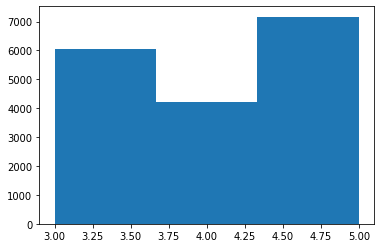

In [17]:
plt.hist(statistics, bins=3)

In [29]:
print(7169/(6068 + 4218 + 7169))

0.41071326267545116


In [23]:
train = []
dev = []
test = []
total = []

train_entities = {}
dev_entities = {}
test_entities = {}
total_entities = {}
is_used = {}


def update_dataset(dataset, entity_dict, et, cp, st, i=-1):
    if i != -1:
        if i in is_used:
            return
        else:
            is_used[i] = True

    st_new = []
    for i in range(len(st)):
        if st[i][-1] != ".":
            st[i] = st[i] + "."
        elif st[i][-2:] == " .":
            st[i] = st[i][:-2] + "."
        st_new.append(st)
            
    dataset.append({"inputs": et, "labels": st})
    for cp_list in cp:
        cp_pairs = [frozenset({cp_list[i], cp_list[j]}) for i in range(len(cp_list) - 1) for j in range(i + 1, len(cp_list))]
        for k in set(cp_pairs):
            if k not in entity_dict:
                entity_dict[k] = 0
            entity_dict[k] += 1


length = len(entitypairs)
for i in range(length):
    et = entitypairs[i]
    cp = concepts[i]
    st = sentences[i]
    update_dataset(total, total_entities, et, cp, st)
    if et == ["dog", "sheep"] or et == ["cloud", "mountain"]:   # example test case
        update_dataset(test, test_entities, et, cp, st, i)


# try to reduce the seen entity pair in the dev/test dataset.
for i in range(length):
    et = entitypairs[i]
    cp = concepts[i]
    st = sentences[i]
    if total_entities[frozenset(et)] > 10:
        update_dataset(train, train_entities, et, cp, st, i)
    else:
        if frozenset(et) in train_entities:
            update_dataset(train, train_entities, et, cp, st, i)

for i in range(length):
    et = entitypairs[i]
    cp = concepts[i]
    st = sentences[i]
    if  total_entities[frozenset(et)] in ([7, 8, 9]):
        if frozenset(et) in train_entities:
            update_dataset(train, train_entities, et, cp, st, i)
        else:
            update_dataset(dev, dev_entities, et, cp, st, i)
    else:
        if frozenset(et) not in train_entities and frozenset(et) in dev_entities:
            update_dataset(dev, dev_entities, et, cp, st, i)

for i in range(length):
    et = entitypairs[i]
    cp = concepts[i]
    st = sentences[i]
    if total_entities[frozenset(et)] in ([2, 3, 4, 5, 6]):
        if frozenset(et) in train_entities:
            update_dataset(train, train_entities, et, cp, st, i)
        elif frozenset(et) in dev_entities:
            update_dataset(dev, dev_entities, et, cp, st, i)
        else:
            update_dataset(test, test_entities, et, cp, st, i)


print(len(train))
print(len(dev))
print(len(test))
print(sum([len(l["labels"]) for l in train]) / len(train))
print(sum([len(l["labels"]) for l in dev]) / len(dev))
print(sum([len(l["labels"]) for l in test]) / len(test))


15263
665
1181
4.125139225578196
3.7097744360902256
3.380186282811177


In [26]:
count_dev = 0
for i in dev:
    et = i["inputs"]
    if frozenset(et) in train_entities:
        count_dev += 1

count_test = 0
for i in test:
    et = i["inputs"]
    if frozenset(et) in train_entities or frozenset(et) in dev_entities:
        count_test += 1

print(1 - count_dev / len(dev))
print(1 - count_test / len(test))

0.9172932330827068
0.983065198983912


In [25]:
with open("../data/train.json", "w") as f:
    for ex in train:
        f.write(json.dumps(ex))
        f.write("\n")

with open("../data/dev.json", "w") as f:
    for ex in dev:
        f.write(json.dumps(ex))
        f.write("\n")

with open("../data/test.json", "w") as f:
    for ex in test:
        f.write(json.dumps(ex))
        f.write("\n")